<a href="https://colab.research.google.com/github/mattdeitke/pytorch/blob/master/final_regularizer_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# torch packages
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import random_split
import torchvision.models as models

# make sure there's access to GPU
assert(torch.cuda.is_available())

# use GPU
device = torch.device("cuda")

# supporting scientific python libraries
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import numpy as np

# random seeds
torch.manual_seed(42)
np.random.seed(42)

# read the data
import json
import os

In [0]:
pip install wandb

In [0]:
import wandb

## Load in the data from Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/basic_pytorch/thermometers')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Custom Dataset to load in all the data

In [0]:
class ThermometersDataset(Dataset):
    def __init__(self, img_dir='images', targets_dir='targets', transform=None):
        # name of each image in the images directory
        self.image_names = os.listdir(img_dir)
        self.length = len(self.image_names)
        
        # save the image and target paths
        self.img_dir = img_dir
        self.targets_dir = targets_dir
        
        # set the data transformer
        self.transform = transform
        
        # load all of the data into ram
        images = []
        targets = []
        for i in range(self.length):
          # keep track of progress
          if i % 50 == 0: print(i, end=', ')
          if i % 1000 == 0 and i != 0: print()
            
          # add next image and its target
          images.append(self.__getimage__(i))
          targets.append(self.__gettarget__(i))

        self.images = images
        self.targets = targets

    def __len__(self):
        return self.length
      
    def __getimage__(self, idx):
      img = Image.open(self.img_dir + '/' + self.image_names[idx])
      if self.transform:
        img = self.transform(img)
        img = img.to(device) 
      return img
    
    def __gettarget__(self, idx):
      with open(self.targets_dir + '/' + self.image_names[idx] + '.json') as json_file:
        target = json.load(json_file)['relative_reading']
      return target

    def __getitem__(self, idx):
      return self.images[idx], self.targets[idx]

#### Image data preprocessing

In [0]:
resize_pix = (512, 128)
data_transform = transforms.Compose([
  transforms.Resize(resize_pix),
  transforms.Lambda(lambda image : image.filter(ImageFilter.FIND_EDGES)),
  transforms.Grayscale(),
  transforms.ToTensor()
])

#### Create Dataset's for both the train and test data

In [11]:
train_tm_dataset = ThermometersDataset(
  img_dir='train/images',
  targets_dir='train/targets',
  transform=data_transform
)

0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 
1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 
2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 
3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 
4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950, 5000, 
5050, 5100, 5150, 5200, 5250, 5300, 5350, 5400, 5450, 5500, 5550, 5600, 5650, 5700, 5750, 5800, 5850, 5900, 5950, 6000, 
6050, 6100, 6150, 6200, 6250, 6300, 6350, 6400, 6450, 6500, 6550, 6600, 6650, 6700, 6750, 6800, 6850, 6900, 6950, 7000, 
7050, 7100, 7150, 7200, 7250, 7300, 7350, 7400, 7450, 7500, 7550, 7600, 7650, 7700, 7750, 7800, 7850, 7900, 7950, 8000, 
8050, 8100, 8150, 8200, 8250, 8300, 8350, 8400, 8

In [12]:
test = ThermometersDataset(
  img_dir='test/images',
  targets_dir='test/targets',
  transform=data_transform
)

0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 

#### Create a validation Dataset

In [0]:
validation_size = 1000
train, val = random_split(train_tm_dataset,
                          [len(train_tm_dataset) - validation_size,
                           validation_size])
assert(len(val) == validation_size)

In [0]:
validation_size = 0
train = train_tm_dataset

#### Data information

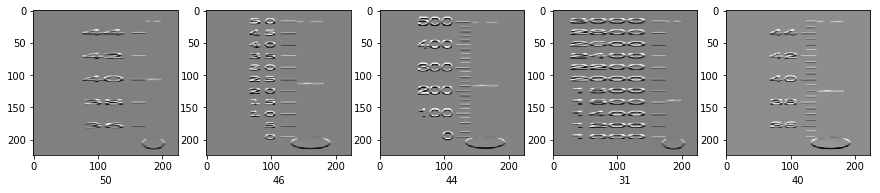

In [0]:
idxs = [0,1,2,3,4]
plt.figure(figsize=(15,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(train[i][0].cpu().numpy().reshape(resize_pix, resize_pix), cmap='gray')
  plt.xlabel(train[i][1])

plt.savefig('transformations.svg', format="svg")
plt.show()

## Training

#### Create a model

In [0]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 16, 3)
    self.conv2 = nn.Conv2d(16, 32, 3)

    self.conv3 = nn.Conv2d(32, 32, 3)
    self.conv4 = nn.Conv2d(32, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)

    self.conv6 = nn.Conv2d(128, 128, 3)
    self.conv7 = nn.Conv2d(128, 256, 3)
    
    self.conv8 = nn.Conv2d(256, 32, 1)

    self.avgpool = nn.AvgPool2d(kernel_size=2,stride=2)
    
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    
    self.fc1 = nn.Linear(5760, 256)
    self.fc2 = nn.Linear(256, 1)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = self.pool(x)
    
    x = F.relu(self.conv6(x))
    x = F.relu(self.conv7(x))
    x = self.pool(x)
    
    x = F.relu(self.conv8(x))
    
    x = self.avgpool(x)

    x = x.view(-1, 5760)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = 100 * torch.sigmoid(x)
    return x

In [0]:
def top1_mse_loss(output, target, net=None, regularizer=5e-6):
  top1_weight = 2
  mae = torch.abs(output - target).type('torch.cuda.FloatTensor')
  mse = ((output - target) ** 2).type('torch.cuda.FloatTensor')
  top1 = (mae > .5).type('torch.cuda.FloatTensor') * mse
  loss = torch.mean(top1_weight * top1 + mse)
  pre_loss = loss  / len(list(net.parameters()))
  if net and regularizer:
    for param in net.parameters():
      loss += pre_loss * regularizer * torch.sum(param ** 2)
  return loss

In [16]:
# get the data
batch_size = 32
train_data = DataLoader(train, batch_size=batch_size)

# Build the network
net = torch.load('try_512_epoch_217.pt')

net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=3e-4)
loss_fn = top1_mse_loss

# hyperparameters
epochs = 10000000
parameters = sum(param.numel() for param in net.parameters())

# log each model
wandb.init(project="thermometers")
try: wandb.watch(net)
except: print('net is already being watch')
wandb.log({'Epochs': epochs,
           'Batch size': batch_size,
           'Parameters': parameters,
           'Optimizer': str(optimizer),
           'Network': str(net),
           'Loss': str(loss_fn),
           'Validation Dataset size': validation_size,
           'Training Dataset size': len(train),
           'Image resize': str(resize_pix)})

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [0]:
def test_model(net, dataset, name=None, max_tests=1000):
  assert(len(dataset) >= max_tests)
  
  net = net.eval()
  
  # initialize metrics
  diff_running_total = 0.0
  within_5 = 0
  within_1 = 0
  within_point5 = 0
  predictions = []
  differences = []
  
  not_within_point5 = [0.0, 0]
  
  # np.random.permutation(len(dataset))[:max_tests]
  idxs = np.arange(max_tests)

  for i, x in enumerate(idxs):
    img, target = dataset[x]
    img = img.reshape(1, 1, resize_pix[0], resize_pix[1])
    pred = net(img).item()
    diff = np.absolute(pred - target)
    
    # update metrics
    diff_running_total += diff
    within_5      += 1 if diff < 5  else 0
    within_1      += 1 if diff < 1  else 0
    
    test_within_point5 = 1 if diff < .5 else 0
    within_point5 += test_within_point5

    predictions.append(pred)
    differences.append(diff)
    
    if not test_within_point5:
      not_within_point5[0] += diff
      not_within_point5[1] += 1

  # normalize metrics
  avg_diff = diff_running_total / max_tests
  within_5 = within_5 / max_tests
  within_1 = within_1 / max_tests
  within_point5 = within_point5 / max_tests
  try:
    not_within_point5 = not_within_point5[0] / not_within_point5[1]
  except:
    print('all instances within .5')
    not_within_point5 = 0

  # log the results if the dataset `name` is supplied
  if name:
      try:
        wandb.log({name + ' avg diff' : avg_diff,
                   name + ' within 5' : within_5,
                   name + ' within 1' : within_1,
                   name + ' within .5': within_point5,
                   name + ' MAE - instances NOT within .5': not_within_point5})
      except:
        print('wandb has not been initialized! Nothing was logged')
  else:
    print('- ' * 25)
    print('avg_diff:', avg_diff)
    print('within_5:', within_5)
    print('within_1:', within_1)
    print('within_point5:', within_point5)
    print('- ' * 25)

  # return the metrics, differences, and predictions as a dictionary
  return {'avg_diff': avg_diff,
          'within_5': within_5,
          'within_1': within_1,
          'within_point5': within_point5,
          'diff': differences,
          'prediction': predictions}

In [0]:
# Build the network
net = torch.load('try_512_epoch_228.pt')

net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
loss_fn = top1_mse_loss

In [105]:
net = net.train()

# iterate for each epoch
for epoch in range(epochs):
  epoch += 280
  # iterate over each batch in the training data
  for batch_idx, (imgs, targets) in enumerate(train_data):
    # Set the parameter gradients to zero
    optimizer.zero_grad()

    # make sure the types are equivalent
    imgs = imgs.type('torch.cuda.FloatTensor')
    targets = targets.type('torch.cuda.FloatTensor')

    # Forward pass
    outputs = net(imgs).reshape([-1])

    # calculate loss and update parameters
    loss = loss_fn(outputs, targets, net, 5e-9)
    loss.backward()
    optimizer.step()

    # track progress
    wandb.log({"Mean batch loss": loss.item()})
    print('[epoch: %s, complete: %s] loss: %s' % (epoch, batch_idx * batch_size, loss.item()))
  
  # log the test and validation accuracy for each epoch
  # test_model(net, val, name='Validation')
  test_model(net, test, name='Validation', max_tests=350)
  test_model(net, train, name='Train')
  
  # save the model for further use
  torch.save(net, 'try_512_epoch_' + str(epoch) + '.pt')

# log specific good and bad predictions from the model
# log_val_good_bad_images()

[epoch: 280, complete: 0] loss: 0.03866325318813324
[epoch: 280, complete: 32] loss: 0.04118065536022186
[epoch: 280, complete: 64] loss: 0.016888482496142387
[epoch: 280, complete: 96] loss: 0.04767304286360741
[epoch: 280, complete: 128] loss: 0.06257888674736023
[epoch: 280, complete: 160] loss: 0.01069763395935297
[epoch: 280, complete: 192] loss: 0.04427122324705124
[epoch: 280, complete: 224] loss: 0.014848158694803715
[epoch: 280, complete: 256] loss: 0.02046465501189232
[epoch: 280, complete: 288] loss: 0.023096900433301926
[epoch: 280, complete: 320] loss: 0.014595416374504566
[epoch: 280, complete: 352] loss: 0.018413465470075607
[epoch: 280, complete: 384] loss: 0.012799665331840515
[epoch: 280, complete: 416] loss: 0.013643947429955006
[epoch: 280, complete: 448] loss: 0.013914776034653187
[epoch: 280, complete: 480] loss: 0.010480912402272224
[epoch: 280, complete: 512] loss: 0.026700614020228386
[epoch: 280, complete: 544] loss: 0.019558751955628395
[epoch: 280, complete:

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[epoch: 281, complete: 0] loss: 0.03400825336575508
[epoch: 281, complete: 32] loss: 0.040664516389369965
[epoch: 281, complete: 64] loss: 0.017865147441625595
[epoch: 281, complete: 96] loss: 0.045819975435733795
[epoch: 281, complete: 128] loss: 0.06622378528118134
[epoch: 281, complete: 160] loss: 0.009769921191036701
[epoch: 281, complete: 192] loss: 0.04308578744530678
[epoch: 281, complete: 224] loss: 0.014389082789421082
[epoch: 281, complete: 256] loss: 0.02222183533012867
[epoch: 281, complete: 288] loss: 0.02339947037398815
[epoch: 281, complete: 320] loss: 0.014095899648964405
[epoch: 281, complete: 352] loss: 0.018241263926029205
[epoch: 281, complete: 384] loss: 0.01244441419839859
[epoch: 281, complete: 416] loss: 0.01440956350415945
[epoch: 281, complete: 448] loss: 0.014467127621173859
[epoch: 281, complete: 480] loss: 0.010987653397023678
[epoch: 281, complete: 512] loss: 0.02584480494260788
[epoch: 281, complete: 544] loss: 0.01935451105237007
[epoch: 281, complete: 5

KeyboardInterrupt: ignored

In [0]:
net(imgs[0,:,:,:].reshape(1,1,512,128)).shape

RuntimeError: ignored

In [0]:
torch.save(net, 'WOW_BASIC_NEW_TOP_new_continous_epoch.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Test model

* `avg_diff`: mean distance between the model's predictions and the target
* `within_5`: percentage of predictions within 5 of the labeled target 
* `within_1`: percentage of predictions within 1 of the labeled target, or has the prediction in the top 2 choices
* `within_point5`: percentage of predictions within 1 of the labeled target, which correctly predicts the label

#### Plot the good and bad results from the validation data

In [0]:
def plot_indicies(idxs, dataset, label=None, wandb_log=False):
  # create the larger figure
  plt.figure(figsize=(15,5))
  
  # create subplots for each idx
  for num, i in enumerate(idxs):

    # i stores (idx, difference=|pred-target|, prediction)
    i, _, pred = i
    
    # create the next subplot
    plt.subplot(1,5,num+1)

    # add label to the far left of the plot
    if num == 0: plt.ylabel(label)
    
    # remove styling
    plt.xticks([]); plt.yticks([])
    
    # show the validation image
    # must be converted to numpy ndarray and reshaped
#     plt.imshow(dataset[i][0])
    plt.imshow(dataset[i][0].cpu().numpy().reshape(resize_pix[0], resize_pix[1]), cmap='gray')
    
    # add information about the image
#     plt.xlabel('%s\nactual: %s, pred: %s' % (dataset.image_paths[i], dataset[i][1], round(pred, 1)))
    plt.xlabel('actual: %s, pred: %s' % (dataset[i][1], round(pred, 1)))

  # log and show the plot
  if wandb_log:
    wandb.log({label.lower(): plt})
  
  plt.savefig(label.lower() + '.svg')
  plt.show()

In [0]:
def log_good_bad_images(test_model, dataset):
  # get each valuation set prediction and difference
#   val_test = test_model(net, test_model)
  idx_distances = [(i, test_model['diff'][i], test_model['prediction'][i])
                   for i in range(len(test_model['prediction']))]
  idx_distances.sort(key=lambda x:-x[1])

  # store the best and worst 
  bad_idxs = idx_distances[:5]
  good_idxs = idx_distances[-5:]

  # make and log the plots
  plot_indicies(bad_idxs, dataset, label='BAD PREDICTIONS')
  plot_indicies(good_idxs, dataset, label='GOOD PREDICTIONS')

In [0]:
test_results = test_model(net, test, max_tests=1000)

- - - - - - - - - - - - - - - - - - - - - - - - - 
avg_diff: 0.0991571296080947
within_5: 1.0
within_1: 0.996
within_point5: 0.97
- - - - - - - - - - - - - - - - - - - - - - - - - 


- - - - - - - - - - - - - - - - - - - - - - - - - 
avg_diff: 0.07262380384607241
within_5: 1.0
within_1: 0.999
within_point5: 0.98
- - - - - - - - - - - - - - - - - - - - - - - - - 


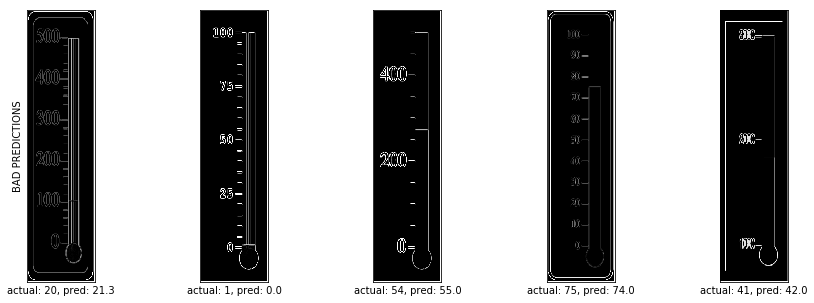

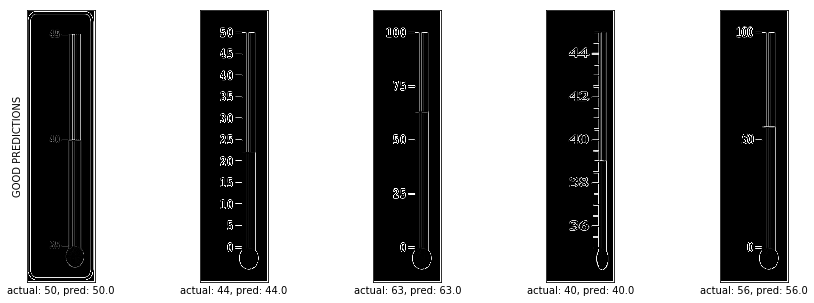

In [25]:
log_good_bad_images(test_model(net, test, max_tests=1000), test)

- - - - - - - - - - - - - - - - - - - - - - - - - 
avg_diff: 0.028698395510614268
within_5: 1.0
within_1: 1.0
within_point5: 0.9999312667537288
- - - - - - - - - - - - - - - - - - - - - - - - - 


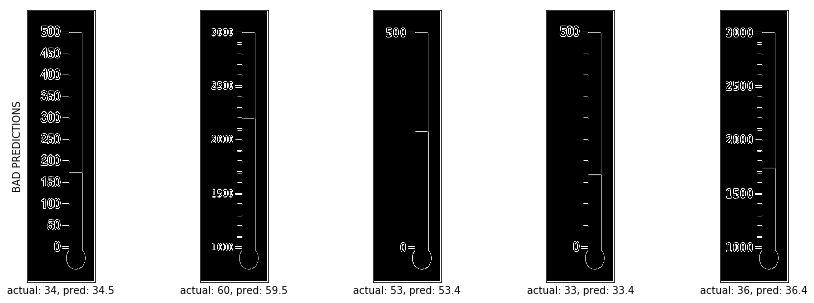

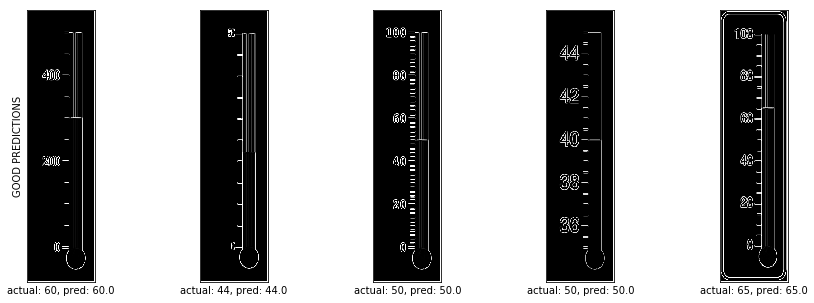

In [26]:
log_good_bad_images(test_model(net, train, max_tests=len(train)), train)

In [0]:
temp_net = net

In [0]:
temp_net = temp_net.to('cpu')

In [50]:
sum([torch.sum(param ** 2).item() for param in temp_net.parameters()])

8086.9700218428625

In [56]:
for param in temp_net.parameters():
  print(param.reshape(-1).shape)

torch.Size([144])
torch.Size([16])
torch.Size([4608])
torch.Size([32])
torch.Size([9216])
torch.Size([32])
torch.Size([18432])
torch.Size([64])
torch.Size([73728])
torch.Size([128])
torch.Size([147456])
torch.Size([128])
torch.Size([294912])
torch.Size([256])
torch.Size([8192])
torch.Size([32])
torch.Size([1474560])
torch.Size([256])
torch.Size([256])
torch.Size([1])
